<a href="https://colab.research.google.com/github/hateley/RAG-chatbot/blob/main/rag_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building a Question and Answer system that uses RAG from drug trail information on Epkinly and Polivy. This system relies primarily on LangChain.

### Install libraries

**We need:**
* **langchain**: This is a library for GenAI. We'll use it to chain together different language models and components for our chatbot.
* **openai**: This is the official OpenAI Python client. We'll use it to interact with the OpenAI API and generate responses for our chatbot.
* **pinecone-client**: This is the official Pinecone Python client. We'll use it to interact with the Pinecone API and store our chatbot's knowledge base in a vector database.

In [87]:
# install necessary libraries
!pip install -qU \
    langchain==0.0.354 \
    openai==1.6.1 \
    datasets==2.10.1 \
    pinecone-client==3.1.0 \
    tiktoken==0.5.2 \
    matplotlib \
    seaborn \
    pandas \
    tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 45.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


## Make a simple chatbot first

In [9]:
#initialize the ChatOpenAI object

import os
from langchain.chat_models import ChatOpenAI
from google.colab import userdata

chat = ChatOpenAI(
    openai_api_key=userdata.get('testkey'),
    model='gpt-3.5-turbo'
)

In [10]:
from langchain.schema import (
    SystemMessage,
    HumanMessage,
    AIMessage
)

messages = [
    SystemMessage(content="You are a helpful assistant."),
    HumanMessage(content="Hi AI, how are you today?"),
    AIMessage(content="I'm great thank you. How can I help you?"),
    HumanMessage(content="I'd like to understand string theory.")
]

In [12]:
#res = chat(messages)
print(res.content)

String theory is a theoretical framework in physics that attempts to reconcile quantum mechanics and general relativity. It posits that the fundamental building blocks of the universe are not point-like particles, but rather tiny, vibrating strings. These strings can give rise to different particles depending on their vibrational patterns.

String theory suggests that there are multiple dimensions beyond the familiar three spatial dimensions and one time dimension. The theory also proposes the existence of different vibrational modes of the strings, which correspond to different particles and forces in the universe.

One of the key ideas in string theory is the concept of supersymmetry, which posits a symmetry between particles with integer spin (bosons) and particles with half-integer spin (fermions). Supersymmetry is believed to help resolve some of the issues in particle physics, such as the hierarchy problem and unifying the fundamental forces of nature.

String theory has generate

In [13]:
# add history so we can continue the conversation

# add latest AI response to messages
messages.append(res)

# now create a new user prompt
prompt = HumanMessage(
    content="Why do physicists believe it can produce a 'unified theory'?"
)
# add to messages
messages.append(prompt)

# send to chat-gpt
res = chat(messages)

print(res.content)

Physicists believe that string theory has the potential to produce a unified theory because it has the ability to incorporate all of the fundamental forces of nature (gravity, electromagnetism, weak nuclear force, and strong nuclear force) within a single framework. In traditional particle physics, these forces are described by different theories (such as quantum field theory for the Standard Model and general relativity for gravity) that do not easily reconcile with each other.

String theory, on the other hand, offers a more comprehensive and consistent framework that can potentially describe all of these forces in a unified manner. By treating particles as vibrating strings in higher-dimensional spacetime, string theory can naturally incorporate gravity along with the other forces. This suggests that all forces and particles in the universe may emerge from a single underlying theory.

Additionally, string theory provides a way to reconcile quantum mechanics with general relativity, 

In [14]:
# right now it doesn't know about the info we want to talk about

# add latest AI response to messages
messages.append(res)

# now create a new user prompt
prompt = HumanMessage(
    content="What were the results of the EPCORE NHL-1 trial?"
)
# add to messages
messages.append(prompt)

# send to OpenAI
res = chat(messages)

messages.append(res)

In [15]:
print(res.content)

The EPCORE NHL-1 trial was a clinical trial evaluating the safety and efficacy of a novel treatment for patients with non-Hodgkin lymphoma (NHL). Unfortunately, as of my last update, I do not have specific information on the results of the EPCORE NHL-1 trial. Clinical trial results are typically published in scientific journals or presented at medical conferences once the study is completed.

If you are interested in the results of the EPCORE NHL-1 trial, I recommend checking clinical trial registries, medical journals, or contacting the researchers involved in the study for more information. Keep in mind that the results of clinical trials can have important implications for patient care and future research in the field of oncology.


## Import data about the clinical trials

In [99]:
import pandas as pd

df = pd.read_csv("/content/scraped.tsv", sep='\t')
df.columns

Index(['fname', 'text'], dtype='object')

In [106]:
from langchain.document_loaders import DataFrameLoader

loader = DataFrameLoader(
    df,
    page_content_column="text"
)
docs = loader.load()

In [107]:
len(docs)

8

In [108]:
print(docs[0].page_content)

polivy_summary.txt.  POLIVY® (polatuzumab vedotin-piiq) Safety Profile             For Patients and Caregivers         MENU          Order Practice Materials       Order Practice Materials        Prescribing Information        Prescribing Information        Contact a Representative        Contact a Representative        Safety       Safety        3L DLBCL Indication       3L DLBCL Indication    Home  About POLIVY  Unmet Need in DLBCL How POLIVY Is Thought to Work  Efficacy  POLARIX Trial POLARIX Trial Results  Safety  POLIVY Side Effects Important Safety Information  Dosing & Administration  Preparation & Storage POLIVY Dosing Administering POLIVY Dose Modifications  Resources  Printable Resources Helpful Links for Your Patients Helpful Resources for Your Practice Practice Forms & Documents  Financial Support  Financial Assistance Options Eligibility & Enrollment Financial Support FAQs   Order Practice Materials Prescribing Information  Contact a Representative  Safety 3L DLBCL Indicat

In [110]:
docs[0].metadata

{'fname': 'polivy_summary.txt'}

In [111]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)


tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

In [112]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

In [113]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 3459
Avg: 6704
Max: 7863


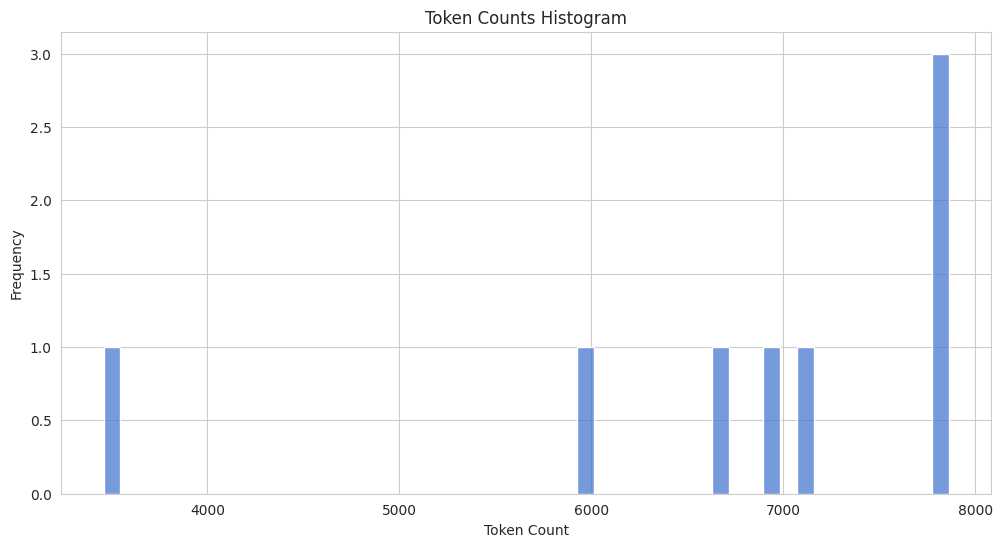

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

In [115]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [117]:
docs[0].metadata


{'fname': 'polivy_summary.txt'}

In [118]:
from tqdm.auto import tqdm

documents = []

for doc in tqdm(docs):
    source = doc.metadata['fname'].replace('.txt', '')
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append({
            'text': chunk,
            'source': source
        })

len(documents)


  0%|          | 0/8 [00:00<?, ?it/s]

149